# Exploring our example datasets further with Exponential Smoothing

Code for plots derived from this series of amazing articles, but modified to fit our data: 
- https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788
- https://towardsdatascience.com/time-series-in-python-part-2-dealing-with-seasonal-data-397a65b74051

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

## Monthly Gas Prices in São Paulo

In [67]:
df = pd.read_csv("../data/gas-prices-2004-2019.tsv", sep="\t")
df = df[(df["PRODUTO"]=="GASOLINA COMUM") & (df["ESTADO"]=="SAO PAULO")][["DATA FINAL", "PREÇO MÉDIO REVENDA"]]
df["DATA FINAL"] = pd.to_datetime(df["DATA FINAL"], format="%Y-%m-%d")
df = (df
      .reset_index(drop=True)
      .rename(columns={"DATA FINAL": "time",
                       "PREÇO MÉDIO REVENDA": "data"})
      .set_index("time")
      .resample("MS").mean())
train = df.iloc[:-10, :]
test = df.iloc[-10:, :]
pred = test.copy()
df.head()

,data
time,
2004-05-01,1.89100
2004-06-01,1.95625
2004-07-01,2.03060
2004-08-01,2.03375
2004-09-01,2.03225


### Checking stationarity via rolling plots

In [69]:
df['z_data'] = (df['data'] - df.data.rolling(window=12).mean()) / df.data.rolling(window=12).std()
df['zp_data'] = df['z_data'] - df['z_data'].shift(12)

In [70]:
def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df.data, label='raw data')
    ax[0].plot(df.data.rolling(window=12).mean(), label="rolling mean");
    ax[0].plot(df.data.rolling(window=12).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=12).mean(), label="rolling mean");
    ax[1].plot(df.z_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df.zp_data, label="12 lag differenced de-trended data")
    ax[2].plot(df.zp_data.rolling(window=12).mean(), label="rolling mean");
    ax[2].plot(df.zp_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

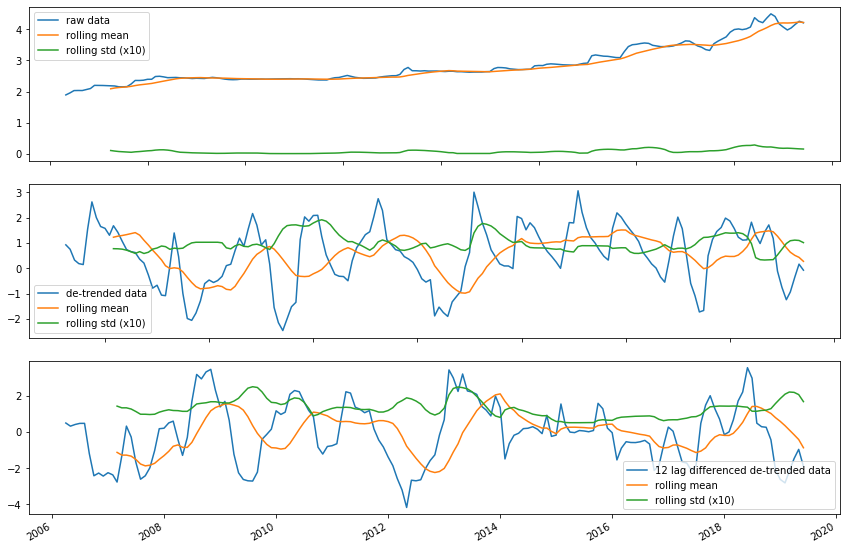

In [71]:
plot_rolling(df)

### Checking stationarity via Augmented Dickey-Fuller Tests

In [72]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(df.data, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df.z_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(df.zp_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = 0.313
P-value = 0.978
Critical values :
	1%: -3.4674201432469816 - The data is not stationary with 99% confidence
	5%: -2.877826051844538 - The data is not stationary with 95% confidence
	10%: -2.575452082332012 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -5.646
P-value = 0.000
Critical values :
	1%: -3.470126426071447 - The data is  stationary with 99% confidence
	5%: -2.8790075987120027 - The data is  stationary with 95% confidence
	10%: -2.5760826967621644 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -3.427
P-value = 0.010
Critical values :
	1%: -3.476273058920005 - The data is not stationary with 99% confidence
	5%: -2.881687616548444 - The data is  stationary with 95% confidence
	10%: -2.5775132580261593 - The data is  stationary with 90% confidence


### Autocorrelation plots

- We want no correlation between the series and lags of itself. 

- We want all the spikes to fall in the blue region of the plot

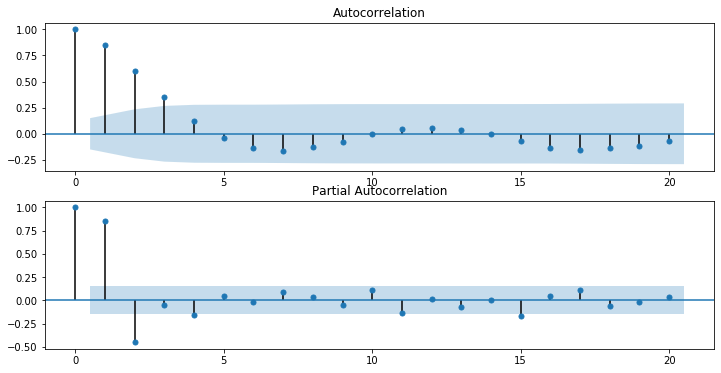

In [73]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df.z_data.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(df.z_data.dropna(), ax=ax[1], lags=20)

Several spikes above the blue region -> there are correlations at lags 1, 2, 3, 4

## Exponential Smoothing

Exponential smoothings methods are appropriate for non-stationary data (ie data with a trend and seasonal data).

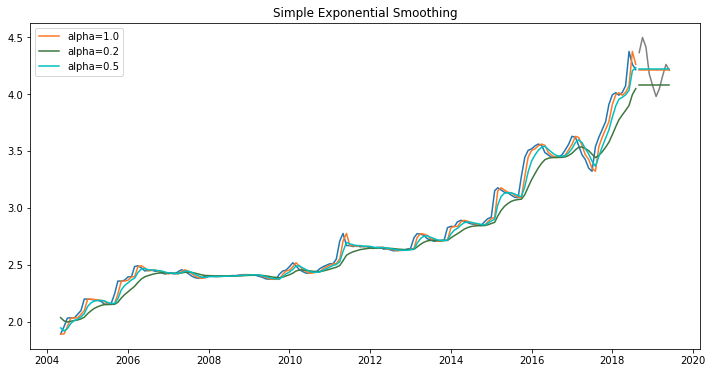

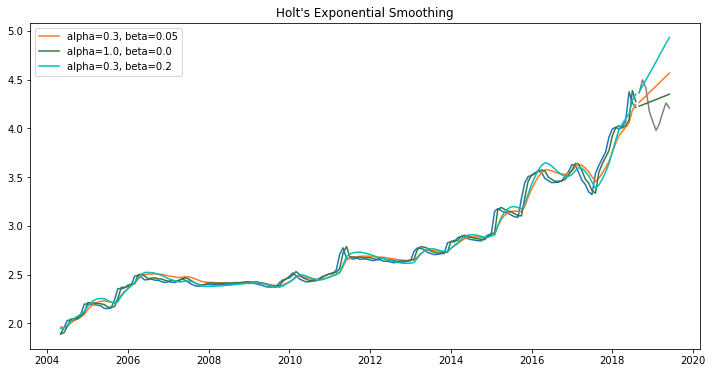

In [91]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

model = SimpleExpSmoothing(np.asarray(train['data']))
model._index = pd.to_datetime(train.index)

fit1 = model.fit()
pred1 = fit1.forecast(10)
fit2 = model.fit(smoothing_level=.2)
pred2 = fit2.forecast(10)
fit3 = model.fit(smoothing_level=.5)
pred3 = fit3.forecast(10)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values)
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Simple Exponential Smoothing")    
plt.legend();
    
model = Holt(np.asarray(train['data']))
model._index = pd.to_datetime(train.index)

fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(10)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(10)
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(10)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values)
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")
plt.legend();

/Users/millengustavo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


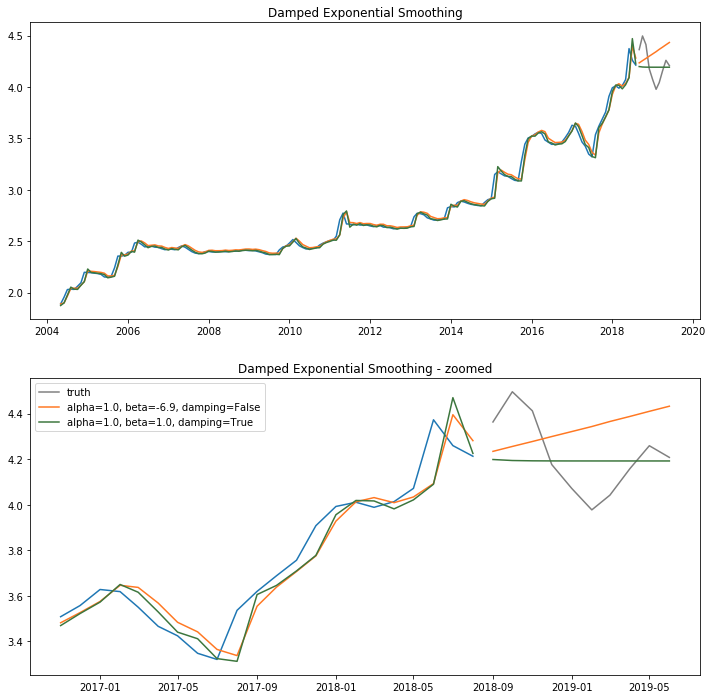

In [95]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

model = ExponentialSmoothing(np.asarray(train['data']), trend='mul', seasonal=None)
model2 = ExponentialSmoothing(np.asarray(train['data']), trend='mul', seasonal=None, damped=True)
model._index = pd.to_datetime(train.index)

fit1 = model.fit()
fit2 = model2.fit()
pred1 = fit1.forecast(10)
pred2 = fit2.forecast(10)

fig, ax = plt.subplots(2, figsize=(12, 12))
ax[0].plot(train.index, train.values)
ax[0].plot(test.index, test.values, color="gray", label="truth")
ax[1].plot(train.index[150:], train.values[150:])
ax[1].plot(test.index, test.values, color="gray", label="truth")
for p, f, c in zip((pred1, pred2),(fit1, fit2),('#ff7823','#3c763d')):
    ax[0].plot(train.index, f.fittedvalues, color=c)
    ax[1].plot(train.index[150:], f.fittedvalues[150:], color=c)
    ax[0].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4]+ ", damping="+str(True if f.params['damping_slope']>0 else False), color=c)
    ax[1].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4]+ ", damping="+str(True if f.params['damping_slope']>0 else False), color=c)
ax[0].set_title("Damped Exponential Smoothing");
ax[1].set_title("Damped Exponential Smoothing - zoomed");
plt.legend();

## Holt-Winter’s Seasonal Smoothing

/Users/millengustavo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/millengustavo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


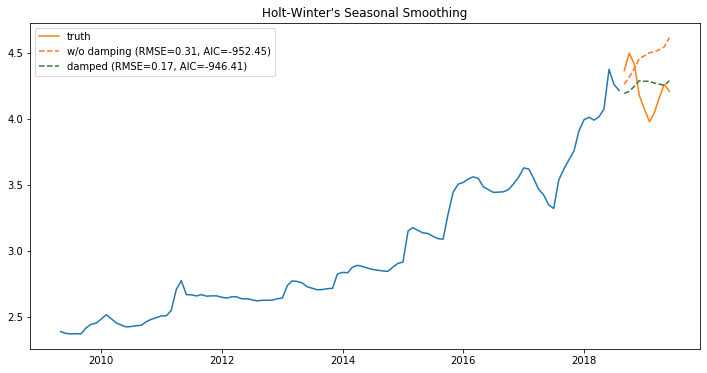

In [97]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12)
model2 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12, damped=True)
fit = model.fit()
pred = fit.forecast(10)
fit2 = model2.fit()
pred2 = fit2.forecast(10)

sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[60:], train.values[60:]);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, pred, linestyle='--', color='#ff7823', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.plot(test.index, pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

## Temperatures in São Paulo

In [118]:
df = pd.read_csv("../data/station_sao_paulo.csv")
df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,D-J-F,M-A-M,J-J-A,S-O-N,metANN
0,1946,999.90,999.90,999.90,999.90,999.90,999.90,999.90,999.90,999.90,999.90,999.90,21.74,999.90,999.90,999.90,999.90,999.90
1,1947,999.90,23.54,21.04,19.74,19.24,999.90,15.04,16.44,18.04,17.04,18.94,20.34,22.75,20.01,15.67,18.01,19.11
2,1948,23.64,22.94,20.74,20.04,18.04,16.64,17.84,15.64,18.64,18.74,20.64,21.24,22.31,19.61,16.71,19.34,19.49
3,1949,22.34,21.54,23.54,19.44,17.24,17.34,16.34,17.34,18.24,18.74,19.74,21.54,21.71,20.07,17.01,18.91,19.42
4,1950,22.14,22.44,22.24,20.44,19.44,17.94,16.44,19.14,19.54,19.04,19.94,21.94,22.04,20.71,17.84,19.51,20.02


In [119]:
df_melt = pd.melt(df, 
                  id_vars=['YEAR'], 
                  value_vars=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC',], 
                  var_name='month',
                  value_name='data')

df_melt["time"] = pd.to_datetime(df_melt['YEAR'].astype(str) + '-' + df_melt['month'].astype(str) + '-01')

df_melt = df_melt.drop(columns=["YEAR", "month"])[["time", "data"]]

df_melt = df_melt.sort_values(by="time")

df_melt["data"] = df_melt["data"].replace(999.90, np.NaN)
df_melt["data"] = df_melt["data"].fillna(method='ffill')
df_melt = df_melt.dropna()
df_melt = df_melt.reset_index(drop=True)
df_melt = df_melt.set_index("time")
df_melt.head()

,data
time,
1946-12-01,21.74
1947-01-01,21.74
1947-02-01,23.54
1947-03-01,21.04
1947-04-01,19.74


In [120]:
df = df_melt.copy()
df = df["1963":] # excluding 1961 and 1962 that we had no data and was imputing above
train = df.iloc[:-24, :]
test = df.iloc[-24:, :]
pred = test.copy()
df['z_data'] = (df['data'] - df.data.rolling(window=12).mean()) / df.data.rolling(window=12).std()
df['zp_data'] = df['z_data'] - df['z_data'].shift(12)

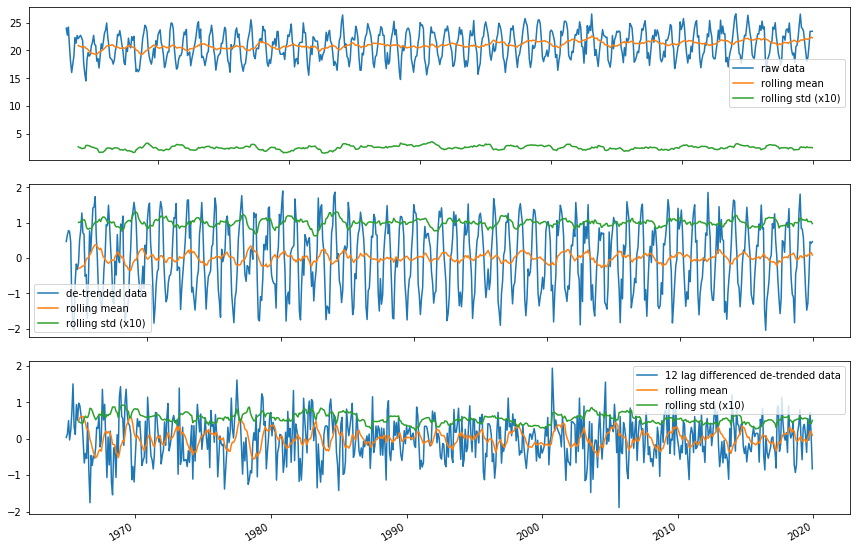

In [121]:
plot_rolling(df)

##  Augmented Dickey-Fuller test

In [122]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(df.data, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df.z_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(df.zp_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -4.212
P-value = 0.001
Critical values :
	1%: -3.4401625092086467 - The data is  stationary with 99% confidence
	5%: -2.865869922737958 - The data is  stationary with 95% confidence
	10%: -2.5690758278089465 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -10.919
P-value = 0.000
Critical values :
	1%: -3.440419374623044 - The data is  stationary with 99% confidence
	5%: -2.865983079837035 - The data is  stationary with 95% confidence
	10%: -2.5691361169972526 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -10.827
P-value = 0.000
Critical values :
	1%: -3.4405132737812596 - The data is  stationary with 99% confidence
	5%: -2.8660244429195725 - The data is  stationary with 95% confidence
	10%: -2.5691581552588447 - The data is  stationary with 90% confidence


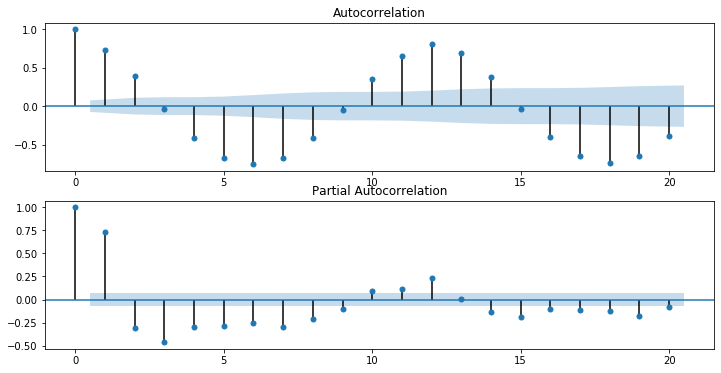

In [123]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df.z_data.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(df.z_data.dropna(), ax=ax[1], lags=20)

/Users/millengustavo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/millengustavo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/millengustavo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


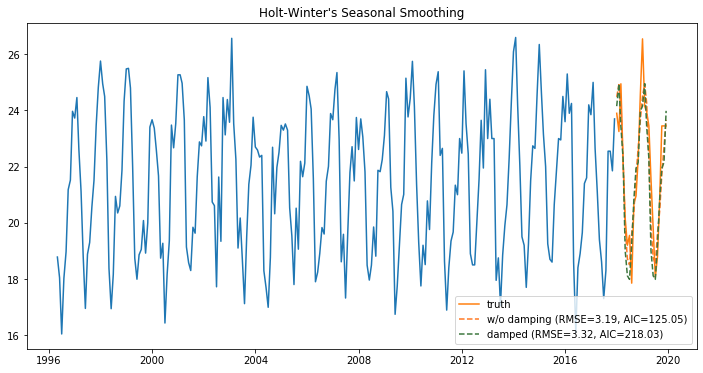

In [125]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12)
model2 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12, damped=True)
fit = model.fit()
pred = fit.forecast(24)
fit2 = model2.fit()
pred2 = fit2.forecast(24)

sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[400:], train.values[400:]);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, pred, linestyle='--', color='#ff7823', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.plot(test.index, pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");